In [9]:
import os
import ase
import json
import mendeleev
import pymatgen
import matplotlib.pyplot as plt
import pandas as pd

from pathlib import Path as path
from collections import defaultdict
from ase.visualize.plot import plot_atoms
from structure_featurization import featurize, featurize_expanded
from ase import io

In [10]:
def get_gpaw_trajectories(defect_db_path:str):
    res = defaultdict(list)
    for file_ in os.listdir(defect_db_path):
        if not file_.startswith("id"):
            continue
        this_folder = os.path.join(defect_db_path, file_, "relaxed", "trajectory")
        for traj_file in os.listdir(this_folder):
            try:
                res[file_].append(ase.io.read(os.path.join(this_folder, traj_file), index=":"))
            except ase.io.formats.UnknownFileTypeError:
                pass
    return res


dataset = get_gpaw_trajectories("./datasets/raw_ruslan_202104/new_datasets/defectDB/")

In [11]:
dataset.keys()

dict_keys(['id43', 'id4', 'id34', 'id44', 'id38', 'id12', 'id31', 'id11', 'id22', 'id15', 'id16', 'id9', 'id27', 'id14', 'id7', 'id24', 'id1', 'id37', 'id13', 'id20', 'id35', 'id36', 'id17', 'id6', 'id28', 'id3', 'id45', 'id18', 'id23', 'id21', 'id5', 'id42', 'id46', 'id33', 'id25', 'id26', 'id30', 'id8', 'id19', 'id40', 'id10', 'id41', 'id29', 'id47', 'id39', 'id32', 'id0', 'id2'])

<AxesSubplot:>

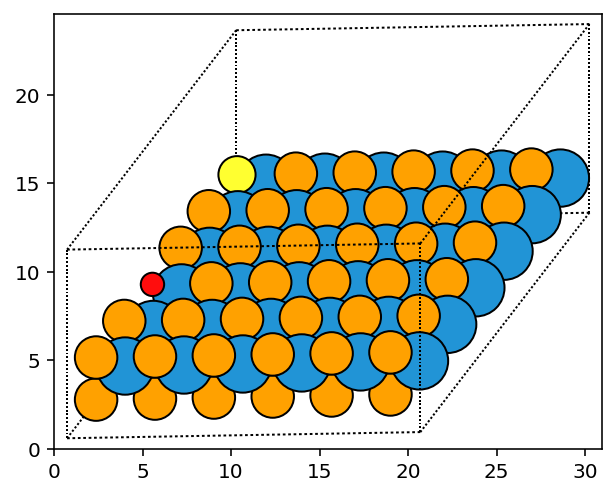

In [17]:
id_prop = []
defect = 'id2'
data_root = path(f'datasets/cgcnn_data_format/{defect}')
data_root.mkdir() if not data_root.exists() else None


def init_atom_feat(atoms: ase.Atom):
    
    def compute_species_params(charge):
        element = mendeleev.element(charge)
        return [charge, element.atomic_volume, element.group_id, element.period]     
    
    atoms_feat = dict()
    for atom, charge in zip(atoms, atoms.get_atomic_numbers()):
        atoms_feat[atom.index] = compute_species_params(int(charge))
        
    return json.dumps(atoms_feat)

matminer_feat = {}
for idx, item in enumerate(dataset[defect][0]):
    # id, target 
    id_prop.append(f'{idx}, {item.get_potential_energy()}\n')
    ase.io.write(data_root.joinpath(f'{idx}.cif'), item, 'cif')
    matminer_feat[idx] = featurize(pymatgen.io.ase.AseAtomsAdaptor.get_structure(item))

with open(data_root.joinpath('id_prop.csv'), 'w') as f:
    f.writelines(id_prop)
with open(data_root.joinpath('atom_init.json'), 'w') as f:
    f.writelines(init_atom_feat(dataset[defect][0][0]))
with open(data_root.joinpath('matminer_feat.json'), 'w') as f:
    f.writelines(json.dumps(matminer_feat))


torch.tensor(list(feat.values())).shape
plot_atoms(dataset[defect][0][0], rotation='135x,1y,1z')


In [12]:
import matplotlib
import pylab

from math import floor, ceil
from random import shuffle
from megnet.models import MEGNetModel
from megnet.data.graph import GaussianDistance
from megnet.data.crystal import CrystalGraph
from megnet.data.molecule import MolecularGraph
from megnet.utils.preprocessing import StandardScaler
from megnet.callbacks import ModelCheckpointMAE
from pymatgen.core import Lattice, Structure, Molecule


cm = pylab.get_cmap('Set1')

import tensorflow as tf
import numpy as np

In [13]:
# tf.config.set_soft_device_placement(True)
# tf.debugging.set_log_device_placement(True)

In [29]:
gc = CrystalGraph(bond_converter=GaussianDistance(np.linspace(0, 5, 100), 0.5), cutoff=6)
# gc = MolecularGraph()
model = MEGNetModel(nfeat_edge=100, nfeat_global=2, graph_converter=gc).from_file('8.9e-4')
# model = MEGNetModel

/home/aziz/.cache/pypoetry/virtualenvs/mos2-potential-learning-BpUrS1CK-py3.8/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [30]:
model.load_weights('callback/val_mae_00132_0.413790.hdf5')

In [32]:
mol = []
target = []
color_label = defaultdict(list)
defect_id = []

for i, defect in enumerate(dataset.keys()):
    try:
        data_len = dataset[defect][0].__len__()
        color_label[defect].append([cm(1 * i / data_len) for j in range(data_len)])
        [defect_id.append(defect.strip('id')) for j in range(data_len)]
        for atoms in dataset[defect][0]:
            mol.append(pymatgen.io.ase.AseAtomsAdaptor.get_molecule(atoms))
            target.append(atoms.get_potential_energy())
            
    except IndexError:
        print('ops')
        
a = list(zip(mol, target, defect_id))
shuffle(a)
mol, target, defect_id = zip(*a)

print(mol.__len__())

955


In [33]:
train_ratio = 0.75
train_len = ceil(mol.__len__() * train_ratio)
val_len = floor(mol.__len__() * (1 - train_ratio))

train_mol = list(mol[:train_len])
train_target = list(target[:train_len])

val_mol = list(mol[train_len:])
val_target = list(target[train_len:])
# val_color_label = color_label[train_len:]
val_defect_id = defect_id[train_len:]

In [34]:
INTENSIVE = False # U0 is an extensive quantity
scaler = StandardScaler.from_training_data(train_mol, train_target, is_intensive=INTENSIVE)
model.target_scaler = scaler

In [233]:
model.train(train_mol, train_target, validation_structures=val_mol, validation_targets=val_target, epochs=400, verbose=1, prev_model='callback/val_mae_00043_0.495604.hdf5')

Epoch 1/400
6/6 [==============================] - 19s 1s/step - loss: 0.0240


INFO:megnet.callbacks:
Epoch 00001: val_mae improved from inf to 2.39027, saving model to callback/val_mae_00001_2.390271.hdf5


Epoch 2/400
6/6 [==============================] - 8s 1s/step - loss: 0.0096


INFO:megnet.callbacks:
Epoch 00002: val_mae improved from 2.39027 to 2.00569, saving model to callback/val_mae_00002_2.005694.hdf5


Epoch 3/400
6/6 [==============================] - 8s 1s/step - loss: 0.0078


INFO:megnet.callbacks:
Epoch 00003: val_mae improved from 2.00569 to 1.09463, saving model to callback/val_mae_00003_1.094626.hdf5


Epoch 4/400
6/6 [==============================] - 8s 1s/step - loss: 0.0046
Epoch 5/400
6/6 [==============================] - 8s 1s/step - loss: 0.0038


INFO:megnet.callbacks:
Epoch 00005: val_mae improved from 1.09463 to 1.00176, saving model to callback/val_mae_00005_1.001759.hdf5


Epoch 6/400
6/6 [==============================] - 8s 1s/step - loss: 0.0028


INFO:megnet.callbacks:
Epoch 00006: val_mae improved from 1.00176 to 0.83865, saving model to callback/val_mae_00006_0.838652.hdf5


Epoch 7/400
6/6 [==============================] - 8s 1s/step - loss: 0.0025


INFO:megnet.callbacks:
Epoch 00007: val_mae improved from 0.83865 to 0.69887, saving model to callback/val_mae_00007_0.698866.hdf5


Epoch 8/400
6/6 [==============================] - 8s 1s/step - loss: 0.0019
Epoch 9/400
6/6 [==============================] - 8s 1s/step - loss: 0.0015


INFO:megnet.callbacks:
Epoch 00009: val_mae improved from 0.69887 to 0.68514, saving model to callback/val_mae_00009_0.685136.hdf5


Epoch 10/400
6/6 [==============================] - 8s 1s/step - loss: 0.0013


INFO:megnet.callbacks:
Epoch 00010: val_mae improved from 0.68514 to 0.60260, saving model to callback/val_mae_00010_0.602604.hdf5


Epoch 11/400
6/6 [==============================] - 8s 1s/step - loss: 0.0014
Epoch 12/400
6/6 [==============================] - 8s 1s/step - loss: 0.0015
Epoch 13/400
6/6 [==============================] - 8s 1s/step - loss: 0.0013
Epoch 14/400
6/6 [==============================] - 8s 1s/step - loss: 0.0013
Epoch 15/400
6/6 [==============================] - 8s 1s/step - loss: 0.0011


INFO:megnet.callbacks:
Epoch 00015: val_mae improved from 0.60260 to 0.56894, saving model to callback/val_mae_00015_0.568936.hdf5


Epoch 16/400
6/6 [==============================] - 8s 1s/step - loss: 0.0012
Epoch 17/400
6/6 [==============================] - 8s 1s/step - loss: 0.0010
Epoch 18/400
6/6 [==============================] - 8s 1s/step - loss: 0.0010
Epoch 19/400
6/6 [==============================] - 8s 1s/step - loss: 9.2110e-04
Epoch 20/400
6/6 [==============================] - 8s 1s/step - loss: 0.0010


INFO:megnet.callbacks:
Epoch 00020: val_mae improved from 0.56894 to 0.54957, saving model to callback/val_mae_00020_0.549574.hdf5


Epoch 21/400
6/6 [==============================] - 8s 1s/step - loss: 8.7640e-04
Epoch 22/400
6/6 [==============================] - 8s 1s/step - loss: 8.9203e-04


INFO:megnet.callbacks:
Epoch 00022: val_mae improved from 0.54957 to 0.52774, saving model to callback/val_mae_00022_0.527736.hdf5


Epoch 23/400
6/6 [==============================] - 8s 1s/step - loss: 7.9541e-04


INFO:megnet.callbacks:
Epoch 00023: val_mae improved from 0.52774 to 0.50753, saving model to callback/val_mae_00023_0.507526.hdf5


Epoch 24/400
6/6 [==============================] - 8s 1s/step - loss: 8.2778e-04
Epoch 25/400
6/6 [==============================] - 8s 1s/step - loss: 7.8020e-04
Epoch 26/400
6/6 [==============================] - 8s 1s/step - loss: 8.7832e-04
Epoch 27/400
6/6 [==============================] - 8s 1s/step - loss: 7.8624e-04
Epoch 28/400
6/6 [==============================] - 8s 1s/step - loss: 7.9945e-04
Epoch 29/400
6/6 [==============================] - 8s 1s/step - loss: 7.4829e-04


INFO:megnet.callbacks:
Epoch 00029: val_mae improved from 0.50753 to 0.50723, saving model to callback/val_mae_00029_0.507230.hdf5


Epoch 30/400
6/6 [==============================] - 8s 1s/step - loss: 7.7529e-04
Epoch 31/400
6/6 [==============================] - 8s 1s/step - loss: 7.2072e-04
Epoch 32/400
6/6 [==============================] - 8s 1s/step - loss: 9.5301e-04
Epoch 33/400
6/6 [==============================] - 8s 1s/step - loss: 9.0196e-04
Epoch 34/400
6/6 [==============================] - 7s 1s/step - loss: 0.0011
Epoch 35/400
6/6 [==============================] - 8s 1s/step - loss: 9.6926e-04
Epoch 36/400
6/6 [==============================] - 8s 1s/step - loss: 7.7573e-04
Epoch 37/400
6/6 [==============================] - 8s 1s/step - loss: 7.4290e-04
Epoch 38/400
6/6 [==============================] - 8s 1s/step - loss: 6.7286e-04


INFO:megnet.callbacks:
Epoch 00038: val_mae improved from 0.50723 to 0.46568, saving model to callback/val_mae_00038_0.465684.hdf5


Epoch 39/400
6/6 [==============================] - 8s 1s/step - loss: 7.4732e-04
Epoch 40/400
6/6 [==============================] - 8s 1s/step - loss: 7.5873e-04
Epoch 41/400
6/6 [==============================] - 8s 1s/step - loss: 6.8832e-04
Epoch 42/400
6/6 [==============================] - 8s 1s/step - loss: 9.8855e-04
Epoch 43/400
6/6 [==============================] - 8s 1s/step - loss: 0.0012
Epoch 44/400
6/6 [==============================] - 8s 1s/step - loss: 9.7718e-04
Epoch 45/400
6/6 [==============================] - 8s 1s/step - loss: 8.3621e-04
Epoch 46/400
6/6 [==============================] - 8s 1s/step - loss: 7.6106e-04
Epoch 47/400
6/6 [==============================] - 8s 1s/step - loss: 7.5054e-04
Epoch 48/400
6/6 [==============================] - 8s 1s/step - loss: 7.1816e-04
Epoch 49/400
6/6 [==============================] - 8s 1s/step - loss: 0.0010
Epoch 50/400
6/6 [==============================] - 8s 1s/step - loss: 0.0012
Epoch 51/400
6/6 [==========

INFO:megnet.callbacks:
Epoch 00109: val_mae improved from 0.46568 to 0.45747, saving model to callback/val_mae_00109_0.457470.hdf5


Epoch 110/400
6/6 [==============================] - 8s 1s/step - loss: 6.0466e-04
Epoch 111/400
6/6 [==============================] - 7s 1s/step - loss: 6.3167e-04
Epoch 112/400
6/6 [==============================] - 8s 1s/step - loss: 7.7855e-04
Epoch 113/400
6/6 [==============================] - 8s 1s/step - loss: 0.0010
Epoch 114/400
6/6 [==============================] - 8s 1s/step - loss: 0.0011
Epoch 115/400
6/6 [==============================] - 7s 1s/step - loss: 0.0013
Epoch 116/400
6/6 [==============================] - 8s 1s/step - loss: 9.9796e-04
Epoch 117/400
6/6 [==============================] - 8s 1s/step - loss: 7.0202e-04
Epoch 118/400
6/6 [==============================] - 7s 1s/step - loss: 6.2503e-04
Epoch 119/400
6/6 [==============================] - 8s 1s/step - loss: 8.0476e-04
Epoch 120/400
6/6 [==============================] - 8s 1s/step - loss: 7.7411e-04
Epoch 121/400
6/6 [==============================] - 8s 1s/step - loss: 7.3668e-04
Epoch 122/400
6/

INFO:megnet.callbacks:
Epoch 00124: val_mae improved from 0.45747 to 0.44548, saving model to callback/val_mae_00124_0.445478.hdf5


Epoch 125/400
6/6 [==============================] - 8s 1s/step - loss: 9.0554e-04
Epoch 126/400
6/6 [==============================] - 8s 1s/step - loss: 0.0010
Epoch 127/400
6/6 [==============================] - 8s 1s/step - loss: 7.2615e-04
Epoch 128/400
6/6 [==============================] - 8s 1s/step - loss: 5.6402e-04
Epoch 129/400
6/6 [==============================] - 8s 1s/step - loss: 5.2538e-04
Epoch 130/400
6/6 [==============================] - 8s 1s/step - loss: 6.8061e-04
Epoch 131/400
6/6 [==============================] - 8s 1s/step - loss: 7.9095e-04
Epoch 132/400
6/6 [==============================] - 8s 1s/step - loss: 6.7179e-04


INFO:megnet.callbacks:
Epoch 00132: val_mae improved from 0.44548 to 0.41379, saving model to callback/val_mae_00132_0.413790.hdf5


Epoch 133/400
6/6 [==============================] - 8s 1s/step - loss: 5.2935e-04
Epoch 134/400
6/6 [==============================] - 7s 1s/step - loss: 5.6733e-04
Epoch 135/400
6/6 [==============================] - 8s 1s/step - loss: 5.8639e-04
Epoch 136/400
6/6 [==============================] - 8s 1s/step - loss: 6.2492e-04
Epoch 137/400
6/6 [==============================] - 8s 1s/step - loss: 5.4369e-04
Epoch 138/400
6/6 [==============================] - 8s 1s/step - loss: 6.2349e-04
Epoch 139/400
6/6 [==============================] - 8s 1s/step - loss: 5.0300e-04
Epoch 140/400
6/6 [==============================] - 8s 1s/step - loss: 7.0034e-04
Epoch 141/400
6/6 [==============================] - 8s 1s/step - loss: 0.0014
Epoch 142/400
6/6 [==============================] - 8s 1s/step - loss: 0.0015
Epoch 143/400
6/6 [==============================] - 8s 1s/step - loss: 0.0015
Epoch 144/400
6/6 [==============================] - 8s 1s/step - loss: 9.7956e-04
Epoch 145/400
6/

In [234]:
model.save_model('8.9e-4')

/home/aziz/.cache/pypoetry/virtualenvs/mos2-potential-learning-BpUrS1CK-py3.8/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: 8.9e-4/assets


INFO:tensorflow:Assets written to: 8.9e-4/assets


In [35]:
def get_cmap(n, name='gnuplot'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def legend_no_dup_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), bbox_to_anchor=(1,1), ncol=2)

In [36]:
predicted_tests = []

foo = defaultdict(list)
for mol, id, target in zip(val_mol, val_defect_id, val_target):
    pred = model.predict_structure(mol).ravel()[0]
    predicted_tests.append(pred)
    foo[id].append((target, pred))

In [37]:
target = np.array(val_target)
pred = np.array(predicted_tests)

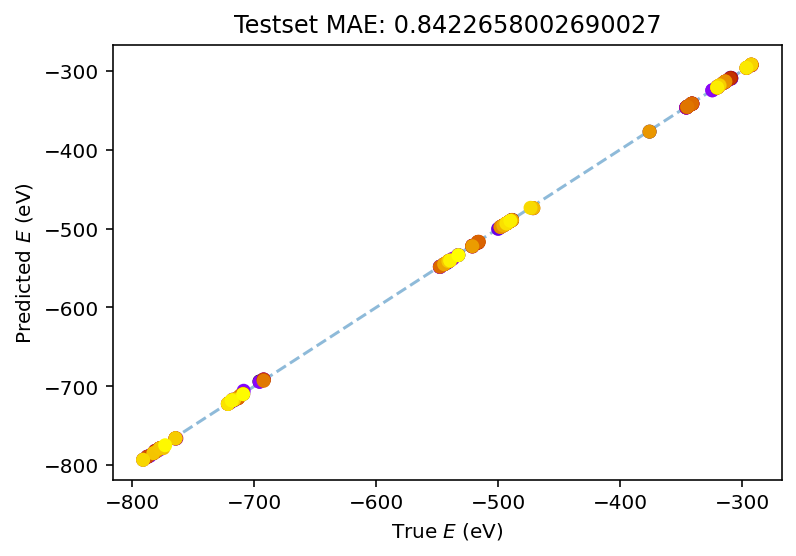

In [38]:
# import matplotlib.pyplot as plt
# %matplotlib inline
cmap = get_cmap(val_mol.__len__())
plt.plot([np.min(val_target), np.max(val_target)], [np.min(val_target), np.max(val_target)], '--', alpha=0.5, zorder=-1)
scatter = plt.scatter(val_target, predicted_tests, c=[cmap(i) for i in range(val_mol.__len__())])
# plt.legend(handles=scatter.legend_elements()[0], labels=val_defect_id,  bbox_to_anchor=(1,1))

plt.xlabel('True $E$ (eV)')
plt.ylabel('Predicted $E$ (eV)')
plt.title(f'Testset MAE: {np.abs(target-pred).mean()}')
plt.savefig('valid_all.png', dpi=192)
plt.show()

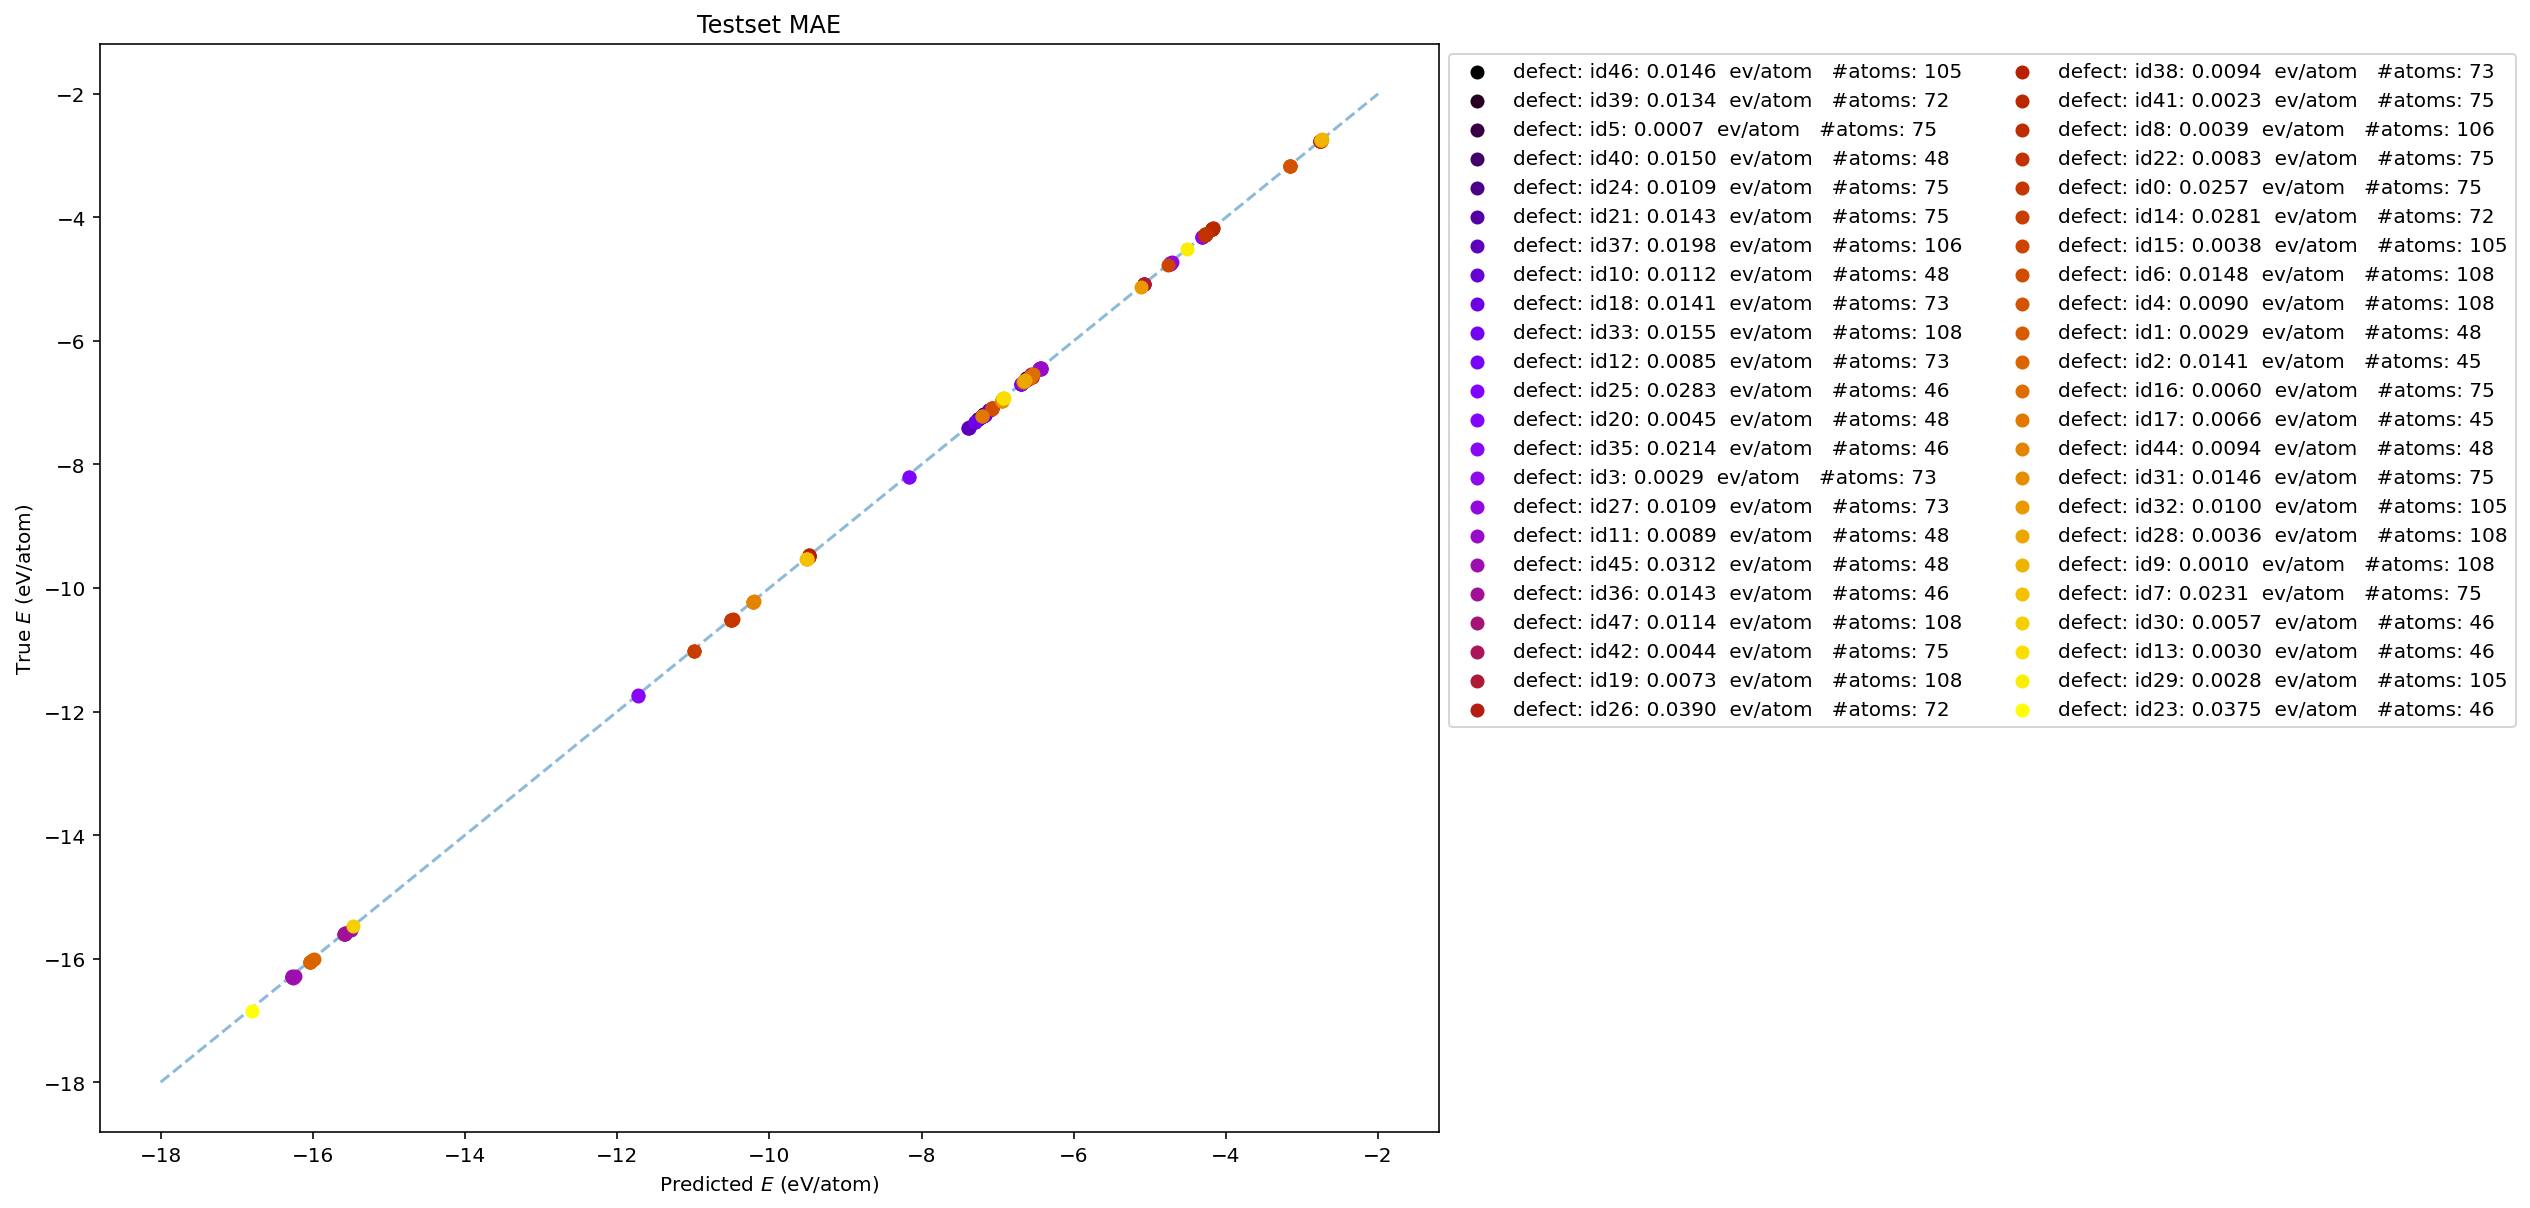

In [70]:
cmap = get_cmap(foo.items().__len__())

fig, axs = plt.subplots(figsize=(12, 10))
t1 = []
t2 = []
for i, ((k, v), mol) in enumerate(zip(foo.items(), val_mol)):
    color = color_label[''.join(['id', k])]
#     for target, pred in v:
    target = []
    pred = []
    for _target, _pred in v:
        target.append(_target)
        pred.append(_pred)
    target = np.array(target)
    pred = np.array(pred)

    _defect = (np.abs(target-pred)/len(mol))

    axs.scatter(target/len(mol), pred/len(mol), label=f'defect: id{k}: {np.mean(_defect).item():.4f}  ev/atom   #atoms: {len(mol)}', color=cmap(i))
axs.plot([-18, -2], [-18, -2], '--', alpha=0.5, zorder=-1)     
legend_no_dup_labels(axs)

axs.set_title('Testset MAE')
axs.set_ylabel('True $E$ (eV/atom)')
axs.set_xlabel('Predicted $E$ (eV/atom)')
plt.savefig('valid_all_defects.png', dpi=192)


In [148]:
mol = []
target = []
defect_id = []
predicted = []
num_atoms = defaultdict(int)

    
for i, defect in enumerate(dataset.keys()):
    try:
        data_len = dataset[defect][0].__len__()
        [defect_id.append(defect) for j in range(data_len)]
        for atoms in dataset[defect][0]:
            num_atoms[defect] = len(atoms)
            mol.append(pymatgen.io.ase.AseAtomsAdaptor.get_molecule(atoms))
            target.append(atoms.get_potential_energy())
            
    except IndexError:
        print('ops')
        

for _mol, _target in zip(mol, target):
    pred = model.predict_structure(_mol).ravel()[0]
    predicted.append(pred)


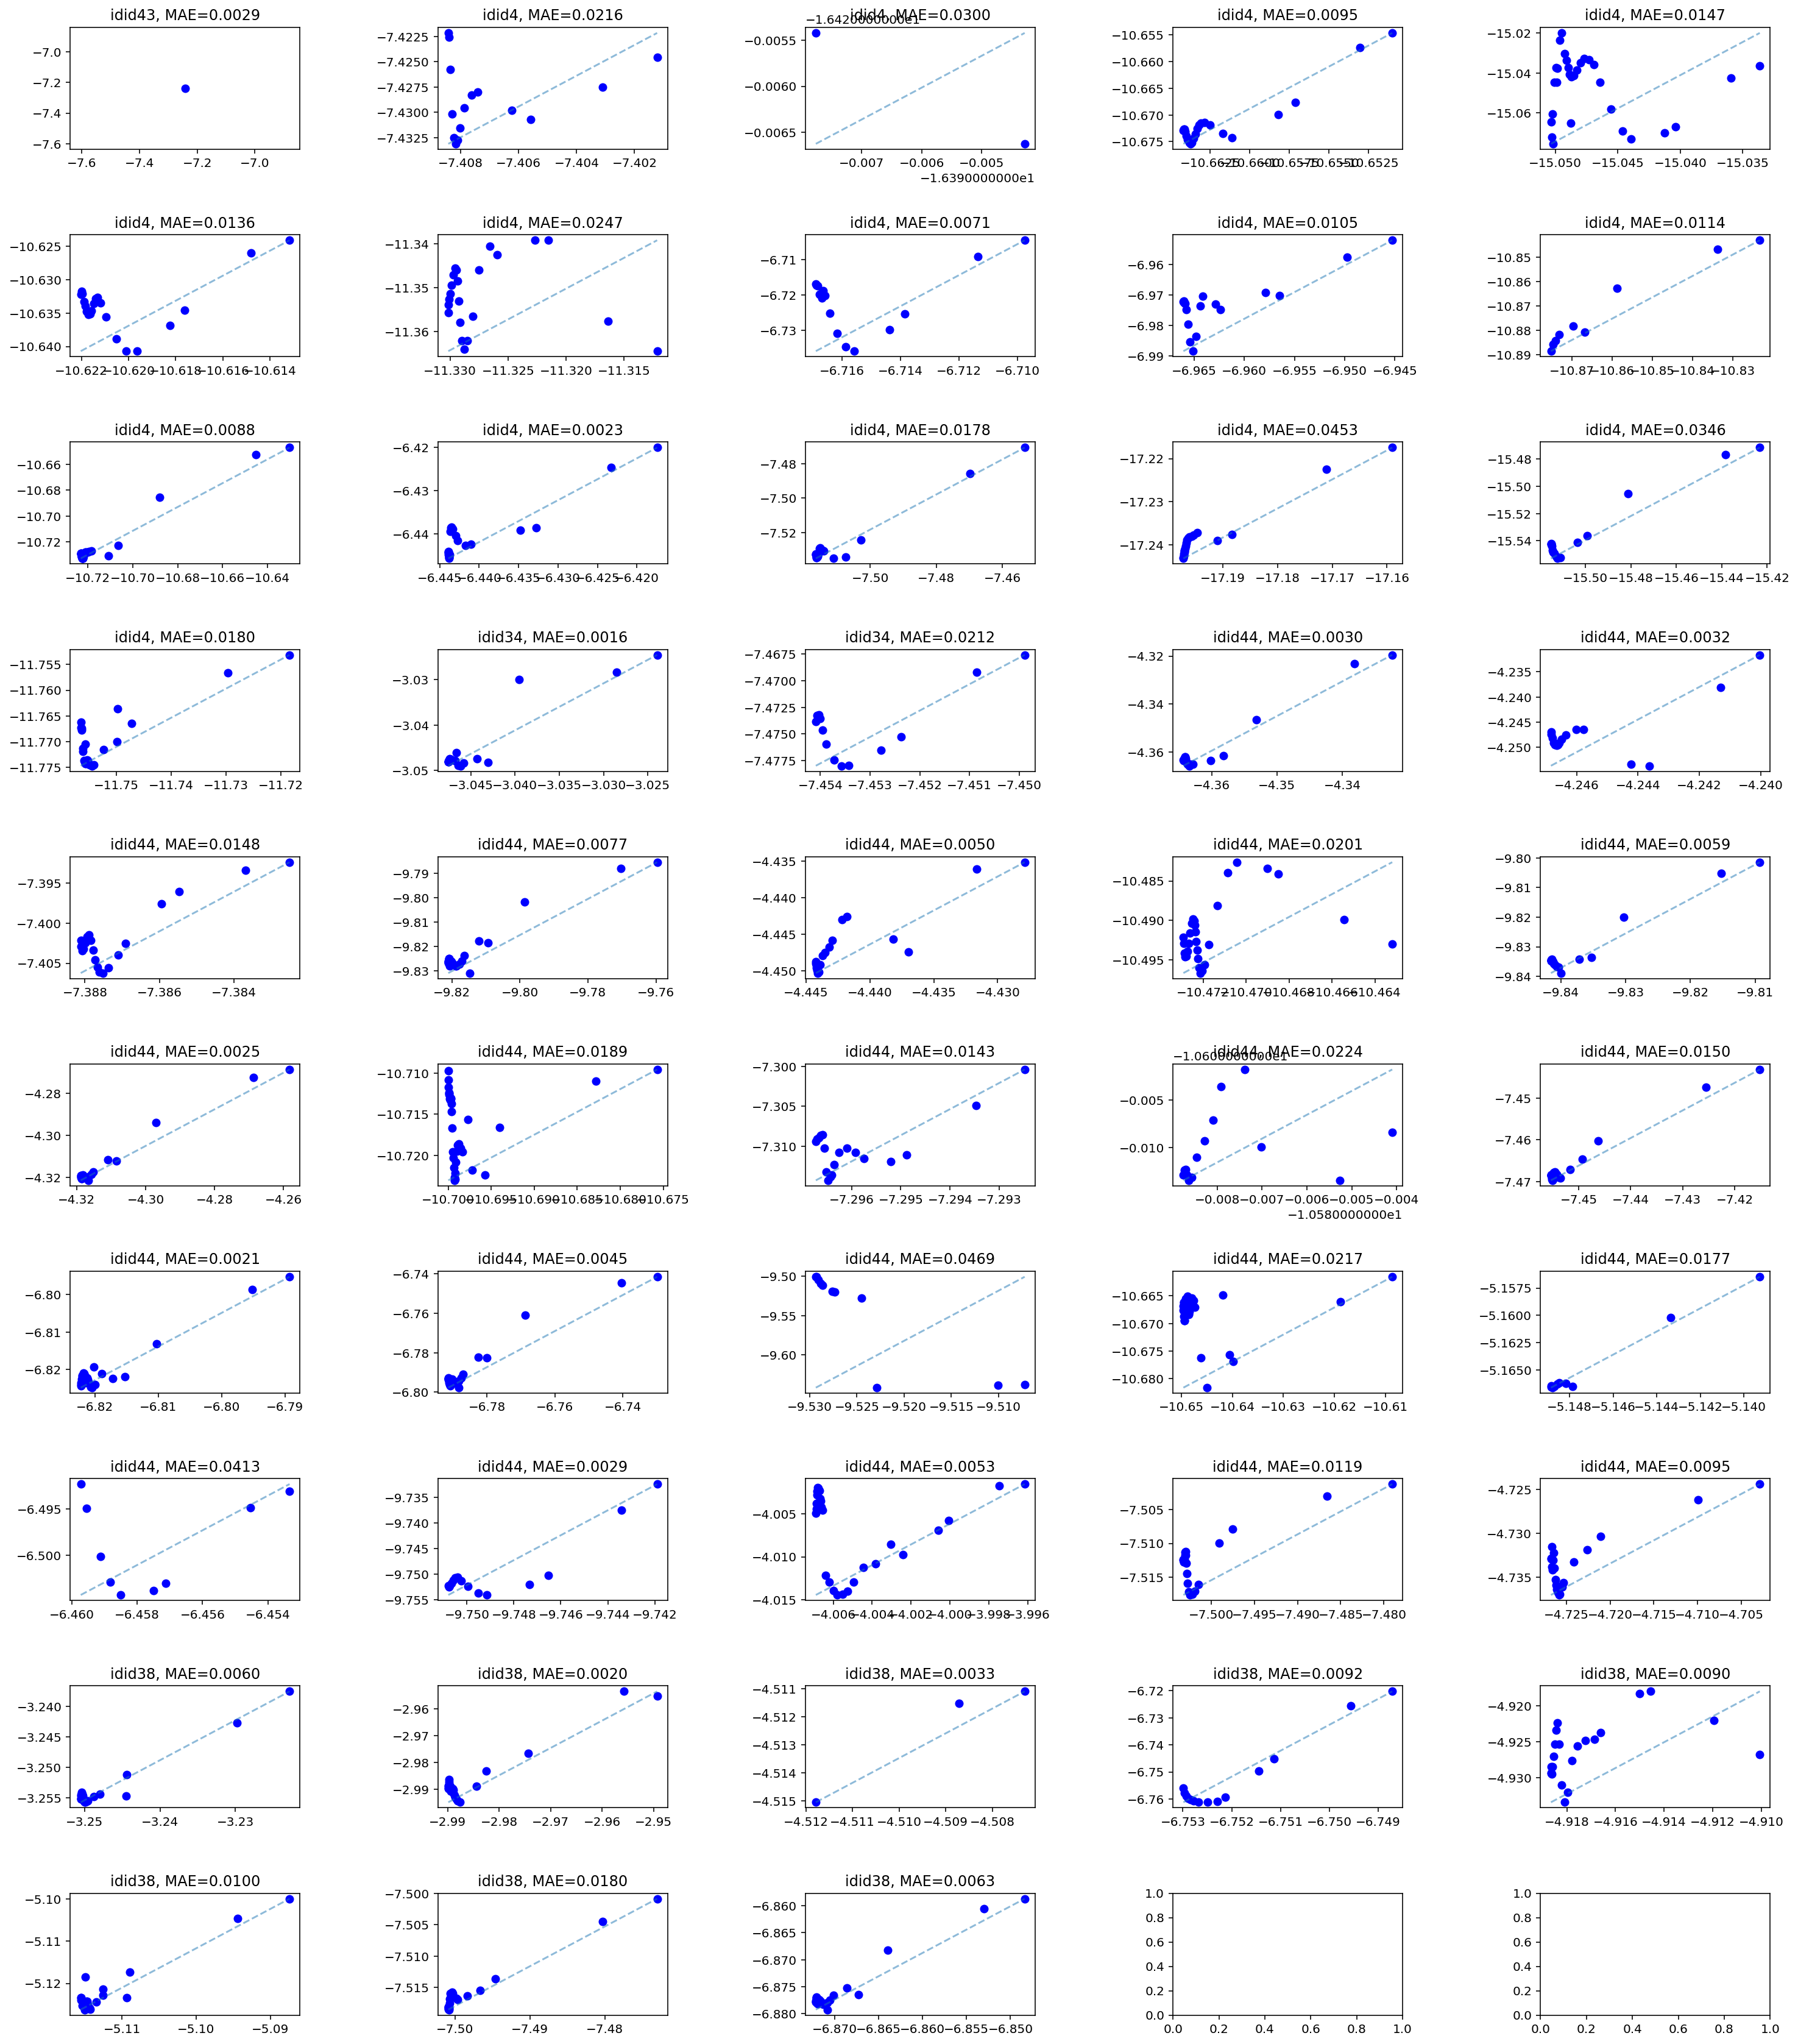

In [150]:
fig, axs = plt.subplots(10, 5, figsize=(25, 30), squeeze=False)

target_dict = defaultdict(list)
pred_dict = defaultdict(list)

for _target, _pred, id in zip(target, predicted, defect_id):
    target_dict[id].append(_target)
    pred_dict[id].append(_pred)


for i, (_target, _pred, id, ax) in enumerate(zip(target_dict.values(), pred_dict.values(), defect_id, axs.flatten())):
    _target = np.array(_target) / num_atoms[id]
    _pred = np.array(_pred) / num_atoms[id]
    ax.scatter(_target, _pred, c='b')
    ax.set_title(f';{id}, MAE={np.abs(np.array(_target) - np.array(_pred)).mean():.04f}')
    xs = [np.min(_target), np.max(_target)]
    ys = [np.min(_pred), np.max(_pred)]
    ax.plot(xs, ys, '--', alpha=0.5)
    
fig.subplots_adjust(hspace=0.7, wspace=0.6)

    

In [145]:
target_dict.values()

dict_values([])

In [142]:
num_atoms

defaultdict(int,
            {'id43': 48,
             'id4': 46,
             'id34': 105,
             'id44': 73,
             'id38': 105,
             'id12': 73,
             'id31': 72,
             'id11': 46,
             'id22': 45,
             'id15': 75,
             'id16': 75,
             'id9': 45,
             'id27': 48,
             'id14': 108,
             'id7': 108,
             'id24': 75,
             'id1': 48,
             'id37': 106,
             'id13': 48,
             'id20': 46,
             'id35': 73,
             'id36': 108,
             'id17': 45,
             'id6': 105,
             'id28': 108,
             'id3': 48,
             'id45': 108,
             'id18': 73,
             'id23': 106,
             'id21': 75,
             'id5': 75,
             'id42': 75,
             'id46': 105,
             'id33': 108,
             'id25': 46,
             'id26': 72,
             'id30': 106,
             'id8': 45,
             'id19': 75,
   